### Translate fasta containing amino acid sequences to comma-free code:

In [44]:
%load_ext blackcellmagic
from Bio import SeqIO

from scipy.spatial.distance import hamming
import itertools
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
# from tqdm import tqdm

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [28]:
# comme-free code AA dictionary
cfcode = {
    "F": "ACC",
    "L": "ACA",
    "I": "ATA",
    "M": "ATC",
    "V": "ATT",
    "S": "CTA",
    "P": "CTC",
    "T": "CTT",
    "A": "AGA",
    "Y": "AGC",
    "H": "AGT",
    "Q": "AGG",
    "N": "CGA", 
    "K": "CGC",
    "D": "CGT",
    "E": "CGG",
    "C": "TGA",
    "W": "TGC",
    "R": "TGT",
    "G": "TGG",
    "X": "NNN",  # Amino acid not known
    "B": "CGT",  # Represents either N or D - will translate as D here (N is only off by one base)
    "J": "ACA",  # Represents either L or I - will translate as L here (I is only off by one base)
    "Z": "CGG"   # Represents either E or Q - will translate as E here (Q is only off by one base)
}

In [40]:
# Also see: https://www.biostars.org/p/432189/
dnacode = {
    'A': 'GCA',
    'C': 'TGC',
    'D': 'GAC',
    'E': 'GAA',
    'F': 'TTC',
    'G': 'GGA',
    'H': 'CAC',
    'I': 'ATA',
    'K': 'AAA',
    'L': 'CTA',
    'M': 'ATG',
    'N': 'AAC',
    'P': 'CCA',
    'Q': 'CAA',
    'R': 'AGA',
    'S': 'AGC',
    'T': 'ACA',
    'V': 'GTA',
    'W': 'TGG',
    'Y': 'TAC',
    "X": "NNN",  # Amino acid not known
    "B": 'AAC',  # Represents either N or D 
    "J": 'CTA',  # Represents either L or I 
    "Z": "GAA" # Represents either E or Q 
}

In [49]:
fasta = "/Users/lauraluebbert/OneDrive - California Institute of Technology/Pachter_lab/comma-free/palmdb/2021-03-14/uniques.fa"

ids = []
seqs = []
nn_seqs = []
cfc_seqs = []
seq_lens = []
for record in SeqIO.parse(fasta, "fasta"):
    # Translate AA sequence to comma-free
    cfc_seq_temp = []
    for aa in record.seq:
        # Capitalize amino acid
        aa = aa.capitalize()

        # Rev translate to comme-free code
        cfc_seq_temp.append(cfcode[aa])

    cfc_seqs.append("".join(cfc_seq_temp))


    # Reverse translate AA sequence using standard dna code
    nn_seq_temp = []
    for aa in record.seq:
        # Capitalize amino acid
        aa = aa.capitalize()

        # Reverse translate
        nn_seq_temp.append(dnacode[aa])

    # Standard reverse translation               
    nn_seqs.append("".join(nn_seq_temp))

    
    # Record original amino acid seq
    seqs.append(record.seq)
    # Record original sequence length
    seq_lens.append(len(record.seq))

    # Record IDs
    ids.append(record.id)

In [ ]:
print(f"Number of sequences: {len(ids)}")
print(f"AA sequence lengths (min-max): {min(seq_lens)} - {max(seq_lens)}")
# Check if all IDs are unique
print("IDs are unique: ",len(ids) == len(set(ids)))
# Check if all sequences are unique
print("Sequences are unique: ", len(cfc_seqs) == len(set(cfc_seqs)))
print("Number of shared sequences: ", len(cfc_seqs) - len(set(cfc_seqs)))

Number of sequences: 296623
AA sequence lengths (min-max): 50 - 250
IDs are unique:  True
Sequences are unique:  False
Number of shared sequences:  62


Hamming distances between sequences in virus reference:

<timed exec>:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


CPU times: user 2min 28s, sys: 901 ms, total: 2min 29s
Wall time: 2min 30s


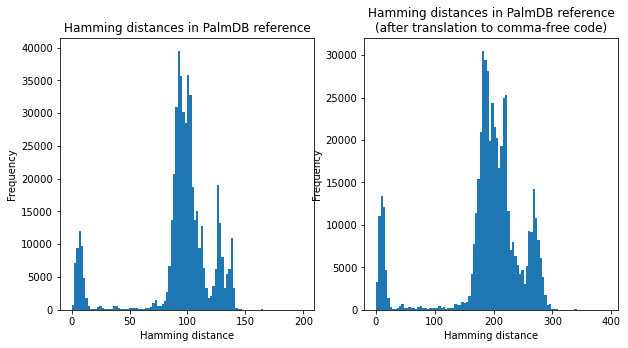

In [ ]:
%%time
# Define number of sequences to compare
n = 1000

# Get Hamming distances between first n AA sequences
hamming_distances = []
for seq1, seq2 in itertools.combinations(seqs[:n], 2):
     # Compute Hamming distance with scipy package (returns percentage that can be converted to Hamming distance by multiplying by length of array)
    if len(seq1) > len(seq2):
        hamming_distance = hamming(list(seq1[:len(seq2)]), list(seq2)) * len(list(seq2))
    elif len(seq2) > len(seq1):
        hamming_distance = hamming(list(seq1), list(seq2[:len(seq1)])) * len(list(seq1))
    else:
        hamming_distance = hamming(list(seq1), list(seq2)) * len(list(seq1))
    hamming_distances.append(hamming_distance)

# Get Hamming distances between first n cfc sequences
hamming_distances_cfc = []
for seq1, seq2 in itertools.combinations(cfc_seqs[:n], 2):
    # Compute Hamming distance with scipy package (returns percentage that can be converted to Hamming distance by multiplying by length of array)
    if len(seq1) > len(seq2):
        hamming_distance = hamming(list(seq1[:len(seq2)]), list(seq2)) * len(list(seq2))
    elif len(seq2) > len(seq1):
        hamming_distance = hamming(list(seq1), list(seq2[:len(seq1)])) * len(list(seq1))
    else:
        hamming_distance = hamming(list(seq1), list(seq2)) * len(list(seq1))
    hamming_distances_cfc.append(hamming_distance)
    
# Plot Hamming distances    
fig, axs = plt.subplots(figsize=(10,5), ncols=2)

ax=axs[0]
ax.hist(hamming_distances, 100)
ax.set_title(f"Hamming distance between the first {n} sequences\nin the PalmDB reference")
ax.set_xlabel("Hamming distance")
ax.set_ylabel("Frequency")

ax=axs[1]
ax.hist(hamming_distances_cfc, 100)
ax.set_title(f"Hamming distance between the first {n} sequences\nin the PalmDB reference\n(after translation to comma-free code)")
ax.set_xlabel("Hamming distance")
ax.set_ylabel("Frequency")

plt.tight_layout()

fig.show()

Note: The Hamming distances for the cfc reverse translated sequences is 3x higher because the sequence becomes 3x longer (every amino acid becomes three "cfc-nucleotides").  

Plot distances as percentage:

In [50]:
%%time
# Define number of sequences to compare
n = 1000

# Get Hamming distances between first n AA sequences
dist_perc = []
for seq1, seq2 in itertools.combinations(seqs[:n], 2):
    if len(seq1) > len(seq2):
        hamming_distance = hamming(list(seq1[:len(seq2)]), list(seq2))
    elif len(seq2) > len(seq1):
        hamming_distance = hamming(list(seq1), list(seq2[:len(seq1)]))
    else:
        hamming_distance = hamming(list(seq1), list(seq2))
    dist_perc.append(hamming_distance)


# Get Hamming distances between first n standard nucleotide sequences
dist_perc_nn = []
for seq1, seq2 in itertools.combinations(nn_seqs[:n], 2):
    if len(seq1) > len(seq2):
        hamming_distance = hamming(list(seq1[:len(seq2)]), list(seq2))
    elif len(seq2) > len(seq1):
        hamming_distance = hamming(list(seq1), list(seq2[:len(seq1)])) 
    else:
        hamming_distance = hamming(list(seq1), list(seq2))
    dist_perc_nn.append(hamming_distance)

# Get Hamming distances between first n cfc sequences
dist_perc_cfc = []
for seq1, seq2 in itertools.combinations(cfc_seqs[:n], 2):
    if len(seq1) > len(seq2):
        hamming_distance = hamming(list(seq1[:len(seq2)]), list(seq2))
    elif len(seq2) > len(seq1):
        hamming_distance = hamming(list(seq1), list(seq2[:len(seq1)])) 
    else:
        hamming_distance = hamming(list(seq1), list(seq2))
    dist_perc_cfc.append(hamming_distance)

CPU times: user 15min 43s, sys: 15.6 s, total: 15min 58s
Wall time: 16min 44s


/var/folders/v8/1_xrn19n71s8w4gbd_215tnr0000gn/T/ipykernel_18518/2620852430.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


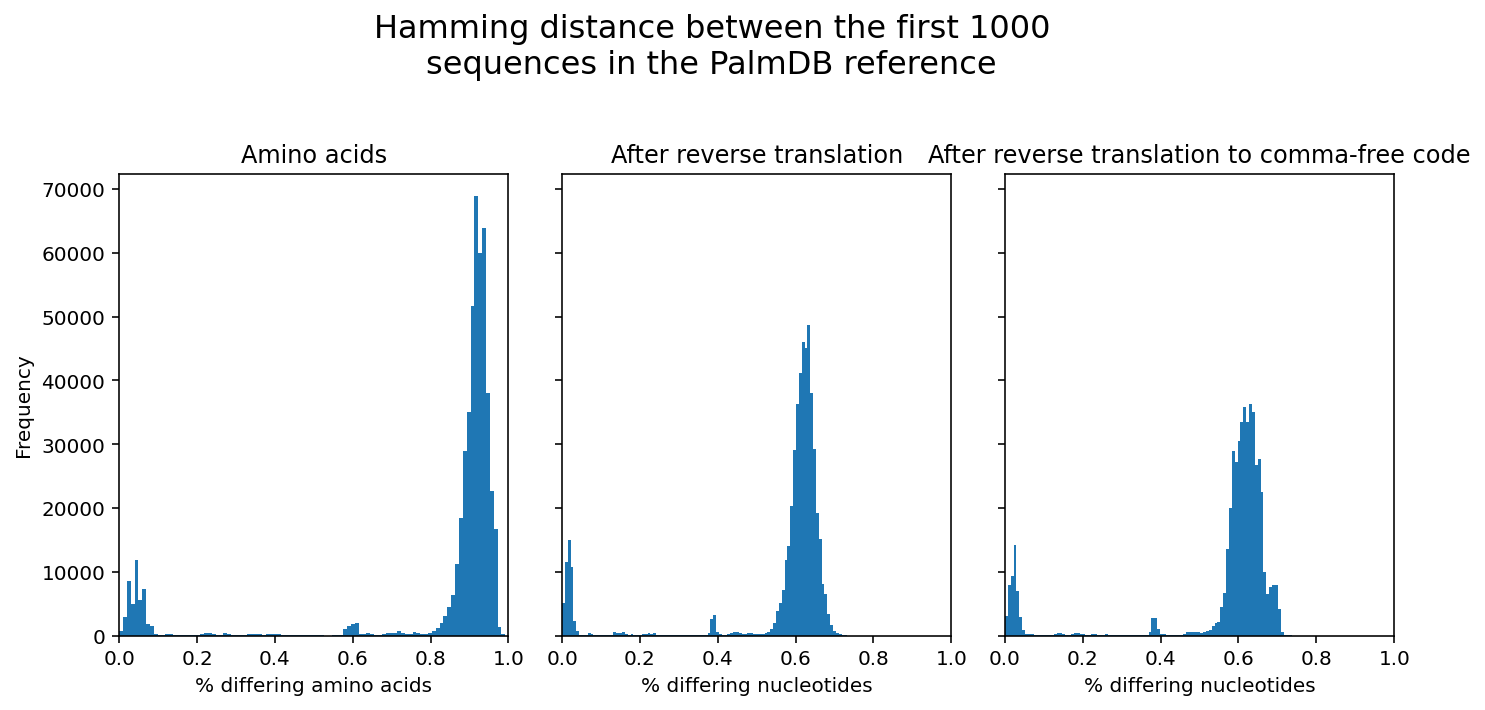

In [51]:
# Plot Hamming distances    
fig, axs = plt.subplots(figsize=(10,5), ncols=3, sharey=True)

fig.suptitle(f"Hamming distance between the first {n}\nsequences in the PalmDB reference\n", fontsize=16)

ax=axs[0]
ax.hist(dist_perc, 100)
ax.set_title(f"Amino acids")
ax.set_xlabel("% differing amino acids")
ax.set_ylabel("Frequency")
ax.set_xlim(0,1.0)

ax=axs[1]
ax.hist(dist_perc_nn, 100)
ax.set_title(f"After reverse translation")
ax.set_xlabel("% differing nucleotides")
# ax.set_ylabel("Frequency")
ax.set_xlim(0,1.0)

ax=axs[2]
ax.hist(dist_perc_cfc, 100)
ax.set_title(f"After reverse translation\nto comma-free code")
ax.set_xlabel("% differing nucleotides")
# ax.set_ylabel("Frequency")
ax.set_xlim(0,1.0)

plt.tight_layout()

fig.savefig("palmdb_dists.png", dpi=300, bbox_inches="tight")

fig.show()

### Build dna and gtf files

In [ ]:
path_to_folder = "../../Pachter_lab/comma-free/palmdb/2021-03-14"

In [ ]:
with open(f"{path_to_folder}/cfc_palmdb_annotation.gtf", "w") as gtf, open(
    f"{path_to_folder}/cfc_palmdb_genome.fa", "w"
) as dna:
    genome_name = "CFCpalmdb1"

    # Add header lines to GTF
    gtf.write(
        f"#!genome-build {genome_name}.1\n#!genome-version {genome_name}\n#!genome-date 2021-03-14\n#!genome-build-accession {genome_name}\n#!genebuild-last-updated 2021-03-14\n")

    start = 1
    chromosome = 1
    for cfc_seq, id in zip(cfc_seqs, ids):
        source = "palmdb"
        features = ["gene", "transcript", "exon", "CDS"]
        frames = [".", ".", ".", "0"]
        end = start  + len(cfc_seq)
        gene_id = id

        for feature, frame in zip(features, frames):
            if feature == "gene":
                gtf.write(
                    f'{chromosome}\t{source}\t{feature}\t{start} {end} .\t+\t{frame}\tgene_id "{gene_id}"; gene_version "1"; gene_name "{gene_id}"; gene_source "palmdb"; gene_biotype "protein_coding";\n'
                    )
            if feature == "transcript":
                gtf.write(
                    f'{chromosome}\t{source}\t{feature}\t{start} {end} .\t+\t{frame}\tgene_id "{gene_id}"; gene_version "1"; transcript_id "{gene_id}T"; transcript_version "1"; gene_name "{gene_id}"; gene_source "palmdb"; gene_biotype "protein_coding"; transcript_name "{gene_id}"; transcript_source "palmdb"; transcript_biotype "protein_coding"; tag "CCDS"; ccds_id "CCDS{gene_id}"; tag "basic";\n'
                )
            if feature == "exon":
                gtf.write(
                    f'{chromosome}\t{source}\t{feature}\t{start} {end} .\t+\t{frame}\tgene_id "{gene_id}"; gene_version "1"; transcript_id "{gene_id}T"; transcript_version "1"; exon_number "1"; gene_name "{gene_id}"; gene_source "palmdb"; gene_biotype "protein_coding"; transcript_name "{gene_id}"; transcript_source "palmdb"; transcript_biotype "protein_coding"; tag "CCDS"; ccds_id "CCDS{gene_id}"; exon_id "{gene_id}E"; exon_version "1"; tag "basic";\n'
                )
            if feature == "CDS":
                gtf.write(
                    f'{chromosome}\t{source}\t{feature}\t{start} {end} .\t+\t{frame}\tgene_id "{gene_id}"; gene_version "1"; transcript_id "{gene_id}T"; transcript_version "1"; exon_number "1"; gene_name "{gene_id}"; gene_source "palmdb"; gene_biotype "protein_coding"; transcript_name "{gene_id}"; transcript_source "palmdb"; transcript_biotype "protein_coding"; tag "CCDS"; ccds_id "CCDS{gene_id}"; protein_id "{gene_id}P"; protein_version "1"; tag "basic";\n'
                    )

        # Build dna/genome file
        dna.write(f">{chromosome} dna:chromosome chromosome:{genome_name}:{chromosome}:{start}:{end}:1 REF\n")
        dna.write(f"{cfc_seq}\n")

        # Add next PALM sequence to new chromosome
        chromosome += 1

Create t2g:

In [ ]:
!cat uniques.fa | awk '{if($1~">") print $1"\t"$1}' > cfc_palmdb_t2g.txt
!sed -i'.original' 's/>u//g' cfc_palmdb_t2g.txt
!rm cfc_palmdb_t2g.txt.original

## Build index and bus file

In [ ]:
# # Generate index with kb (DOES NOT WORK - DELANEY SAYS HE HAS THE SAME PROBLEM WITH KB REF)
# !kb ref \
#     -i $path_to_folder/kb/cfc_palmdb_kb_index.idx \
#     -g $path_to_folder/kb/cfc_palmdb_t2g.txt \
#     -f1 $path_to_folder/kb/cfc_palmdb_transcriptome.fa \
#     $path_to_folder/cfc_palmdb_genome.fa \
#     $path_to_folder/cfc_palmdb_annotation.gtf

In [ ]:
# Generate kallisto index
!kallisto index \
    -i $path_to_folder/cfc_palmdb_index.idx \
    $path_to_folder/cfc_palmdb_genome.fa


[build] loading fasta file ../../../Pachter_lab/comma-free/palmdb/2021-03-14/cfc_palmdb_genome.fa
[build] k-mer length: 31
[build] warning: replaced 114207 non-ACGUT characters in the input sequence
        with pseudorandom nucleotides
KmerStream::KmerStream(): Start computing k-mer cardinality estimations (1/2)
KmerStream::KmerStream(): Start computing k-mer cardinality estimations (1/2)
KmerStream::KmerStream(): Finished
CompactedDBG::build(): Estimated number of k-mers occurring at least once: 38457212
CompactedDBG::build(): Estimated number of minimizer occurring at least once: 8030027
CompactedDBG::filter(): Processed 88645809 k-mers in 296623 reads
CompactedDBG::filter(): Found 38301304 unique k-mers
CompactedDBG::filter(): Number of blocks in Bloom filter is 262893
CompactedDBG::construct(): Extract approximate unitigs (1/2)
CompactedDBG::construct(): Extract approximate unitigs (2/2)
CompactedDBG::construct(): Closed all input files

CompactedDBG::construct(): Splitting uniti